In [7]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [8]:
def compute_metrics(y_train, pred_train, y_test, pred_test, metrics='macro'):
    train_accuracy = accuracy_score(y_train, pred_train)
    train_f1 = f1_score(y_train, pred_train, average=metrics)
    train_precision = precision_score(y_train, pred_train, average=metrics)
    train_recall = recall_score(y_train, pred_train, average=metrics)
    train_labels = np.unique(y_train)  # Unique labels in y_train
    train_confusion = confusion_matrix(y_train, pred_train, labels=train_labels)
    train_confusion = train_confusion.astype('float') / train_confusion.sum(axis=1)[:, np.newaxis]

    test_accuracy = accuracy_score(y_test, pred_test)
    test_f1 = f1_score(y_test, pred_test, average=metrics)
    test_precision = precision_score(y_test, pred_test, average=metrics)
    test_recall = recall_score(y_test, pred_test, average=metrics)
    test_labels = np.unique(y_test)  # Unique labels in y_test
    test_confusion = confusion_matrix(y_test, pred_test, labels=test_labels)
    test_confusion = test_confusion.astype('float') / test_confusion.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(train_confusion, annot=True, linewidths=0.01, ax=axes[0], xticklabels=train_labels, yticklabels=train_labels)
    axes[0].set_title("Confusion Matrix (Training Set)")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")
    sns.heatmap(test_confusion, annot=True, linewidths=0.01, ax=axes[1], xticklabels=test_labels, yticklabels=test_labels)
    axes[1].set_title("Confusion Matrix (Testing Set)")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")
    plt.tight_layout()
    plt.show()

    print("Training Set Metrics:")
    print("Accuracy:", train_accuracy)
    print("F1 Score:", train_f1)
    print("Precision:", train_precision)
    print("Recall:", train_recall)
    print("\nTesting Set Metrics:")
    print("Accuracy:", test_accuracy)
    print("F1 Score:", test_f1)
    print("Precision:", test_precision)
    print("Recall:", test_recall)


In [9]:
# Load features and labels from csv file
data = pd.read_csv('Data/train_features_complete.csv')
test_data = pd.read_csv('Data/test_features_complete.csv')

data

,patient_id,QRS_duration,PR_duration,QT_duration,QS_duration,ST_duration,P_amplitude,Q_amplitude,R_amplitude,S_amplitude,...,ShannonEntropy,KSTestValue,median_RRinterval,ifa_index_ratio,QRS_similarity,R_similarity,HighBeats_similarity,SQindex,noisy,label
0,A00003,0.116667,0.183333,0.390000,0.073333,0.271667,0.034481,-0.071508,0.440171,-0.163829,...,2.579706,0.000075,0.740000,0.037037,0.328667,0.495242,0.260774,0.068437,0.0,N
1,A00006,0.100000,0.231667,0.563333,0.076667,0.465000,0.003377,-0.131043,0.418409,-0.043234,...,2.032448,0.051065,1.050000,0.000000,0.495149,0.496485,0.488420,0.010113,0.0,N
2,A00007,0.106667,0.346667,0.393333,0.066667,0.286667,0.019863,-0.104394,0.767334,-0.385454,...,2.282450,0.028150,0.958333,0.000000,0.484807,0.499702,0.481539,0.031414,0.0,N
3,A00010,0.150000,0.306667,0.380000,0.108333,0.233333,0.053853,-0.481069,0.077982,0.038167,...,2.481113,0.156296,0.916667,0.000000,0.367022,0.447609,0.331216,0.063530,0.0,N
4,A00012,0.156667,0.240000,0.460000,0.106667,0.310000,0.022744,-0.045028,0.631899,-0.238866,...,0.994354,0.047170,0.906667,0.000000,0.262300,0.498202,0.260185,0.075225,0.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6809,A08524,0.141667,0.235000,0.491667,0.120000,0.360000,-0.000310,-0.019917,0.279481,-0.045783,...,2.006100,0.069601,0.863333,0.000000,0.427157,0.473614,0.279944,0.009474,0.0,N
6810,A08525,0.143333,0.123333,0.528333,0.126667,0.361667,-0.049929,-0.095407,0.945614,-0.223382,...,1.508623,0.960201,0.750000,0.097561,0.455847,0.440901,0.266730,0.094587,0.0,O
6811,A08526,0.110000,0.253333,0.380000,0.073333,0.270000,0.026138,-0.148380,0.784132,-0.176948,...,2.580292,0.010224,0.823333,0.000000,0.429114,0.491379,0.308693,0.054189,0.0,N
6812,A08527,0.133333,0.136667,0.353333,0.083333,0.216667,0.061149,-0.066459,0.422337,-0.156667,...,2.520160,0.009737,0.610000,0.060000,0.352159,0.487432,0.265389,0.124735,0.0,N


In [10]:
print(data.shape)
print(test_data.shape)
print(data['label'].value_counts())

(6814, 23)
(1705, 23)
label
N    4040
O    1965
A     581
~     228
Name: count, dtype: int64


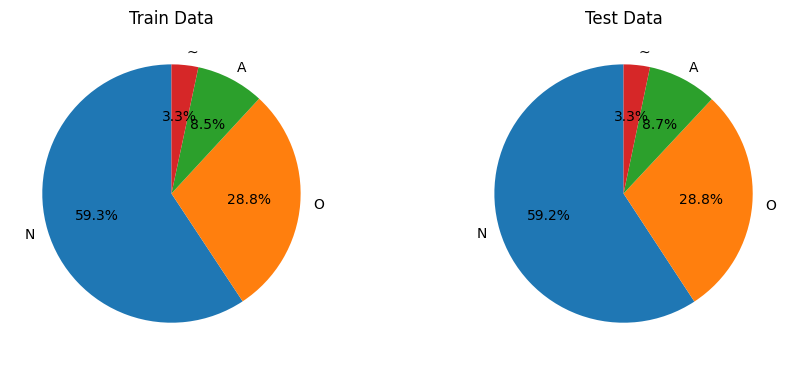

In [11]:
# Find the label distribution and plot a pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Train data subplot
train_distribution = data['label'].value_counts(normalize=True)
ax1.pie(train_distribution, labels=train_distribution.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Train Data')

# Test data subplot
test_distribution = test_data['label'].value_counts(normalize=True)
ax2.pie(test_distribution, labels=test_distribution.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Test Data')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()


In [12]:
data.describe()

,QRS_duration,PR_duration,QT_duration,QS_duration,ST_duration,P_amplitude,Q_amplitude,R_amplitude,S_amplitude,T_amplitude,...,Radius,ShannonEntropy,KSTestValue,median_RRinterval,ifa_index_ratio,QRS_similarity,R_similarity,HighBeats_similarity,SQindex,noisy
count,6683.000000,6683.000000,6683.000000,6683.000000,6683.000000,6683.000000,6683.000000,6683.000000,6683.000000,6683.000000,...,6683.000000,6683.000000,6683.000000,6683.000000,6683.000000,6683.000000,6683.000000,6683.000000,6683.000000,6814.000000
mean,0.133467,0.232846,0.412265,0.092581,0.279463,0.050437,-0.142912,0.627399,-0.218189,0.149935,...,123.552297,2.078620,0.199551,0.835271,0.078585,0.369134,0.482413,0.314431,0.082490,0.019225
std,0.021985,0.136842,0.079314,0.022756,0.077734,0.081247,0.168044,0.383837,0.177833,0.125979,...,156.412025,0.479997,0.296760,0.232183,0.122493,0.095111,0.024986,0.106809,0.101361,0.137325
min,0.066667,0.003333,0.176667,0.040000,0.016667,-0.416614,-1.844842,-0.013205,-2.061580,-0.402717,...,10.000000,-0.000000,0.000000,0.273333,0.000000,0.024371,0.148170,-0.022491,0.000000,0.000000
25%,0.120000,0.163333,0.376667,0.073333,0.250000,0.026315,-0.139754,0.351876,-0.294832,0.089246,...,20.000000,1.849562,0.007852,0.716667,0.000000,0.288104,0.471856,0.223382,0.034182,0.000000
50%,0.133333,0.216667,0.410000,0.091667,0.280000,0.041633,-0.093113,0.600899,-0.188799,0.131437,...,50.000000,2.242778,0.040228,0.831667,0.020408,0.370905,0.493885,0.296445,0.054914,0.000000
75%,0.146667,0.286667,0.445000,0.111667,0.310000,0.059520,-0.062828,0.839998,-0.122237,0.184508,...,160.000000,2.428738,0.270482,0.945000,0.111111,0.466665,0.498522,0.411624,0.096037,0.000000
max,0.201667,7.228333,3.943333,0.160000,3.833333,3.548189,0.560739,5.199770,1.441975,3.396313,...,580.000000,2.727267,1.000000,9.330000,0.882353,0.499157,0.499982,0.499091,2.584369,1.000000


In [13]:
data[data['label']=='~']

,patient_id,QRS_duration,PR_duration,QT_duration,QS_duration,ST_duration,P_amplitude,Q_amplitude,R_amplitude,S_amplitude,...,ShannonEntropy,KSTestValue,median_RRinterval,ifa_index_ratio,QRS_similarity,R_similarity,HighBeats_similarity,SQindex,noisy,label
14,A00022,0.176667,0.043333,0.280000,0.130000,0.143333,0.106304,-0.070390,0.280562,-0.165423,...,1.039721,0.864784,0.455000,0.500000,0.252094,0.230110,0.017263,0.138367,0.0,~
24,A00034,0.181667,0.275000,0.453333,0.125000,0.288333,0.064689,-0.114680,0.701019,-0.148333,...,1.794697,0.561013,1.026667,0.285714,0.328539,0.433060,0.191710,0.292217,0.0,~
41,A00056,0.148333,0.115000,0.290000,0.105000,0.140000,0.108621,-0.162240,0.519327,-0.132413,...,2.088691,0.180488,0.523333,0.307692,0.243406,0.444591,0.151402,0.252646,0.0,~
77,A00106,0.166667,0.226667,0.351667,0.126667,0.213333,0.084564,-1.146478,0.161155,0.134731,...,1.758243,0.893479,0.893333,0.105263,0.481751,0.494152,0.473559,0.258424,0.0,~
91,A00125,0.148333,0.091667,0.275000,0.108333,0.108333,0.138376,-0.244749,0.143034,-0.174881,...,2.540565,0.041554,0.473333,0.436364,0.258508,0.444816,0.193387,0.185135,0.0,~
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6708,A08408,0.173333,0.120000,0.403333,0.130000,0.250000,0.033160,-0.094604,1.606950,-0.353134,...,1.352209,0.494156,0.623333,0.214286,0.223510,0.490411,0.149915,0.670055,0.0,~
6756,A08464,0.143333,0.186667,0.328333,0.106667,0.198333,0.168153,-0.192750,0.568695,-0.223195,...,2.241508,0.243001,0.646667,0.333333,0.251507,0.418054,0.151550,0.406407,0.0,~
6760,A08468,0.143333,0.163333,0.360000,0.106667,0.203333,0.158724,-0.154078,0.551024,-0.240194,...,2.418897,0.060150,0.596667,0.344828,0.223956,0.410638,0.133889,0.294763,0.0,~
6779,A08489,0.146667,0.150000,0.358333,0.108333,0.231667,0.042705,-0.086871,0.661900,-0.142566,...,2.436762,0.208438,0.676667,0.265306,0.267428,0.435070,0.150864,0.251018,0.0,~


In [14]:
data[data['noisy']>0]

,patient_id,QRS_duration,PR_duration,QT_duration,QS_duration,ST_duration,P_amplitude,Q_amplitude,R_amplitude,S_amplitude,...,ShannonEntropy,KSTestValue,median_RRinterval,ifa_index_ratio,QRS_similarity,R_similarity,HighBeats_similarity,SQindex,noisy,label
40,A00055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,O
146,A00196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,~
163,A00217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,A
238,A00316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,N
284,A00371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6644,A08327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,N
6658,A08344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,N
6685,A08377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,~
6780,A08490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,O


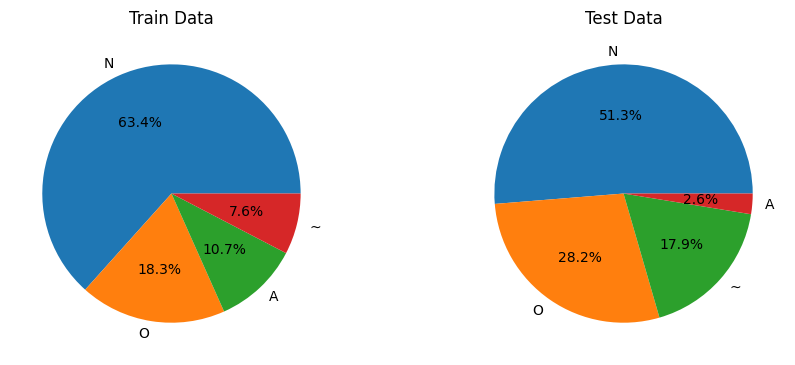

In [15]:
# Find the label distribution and plot a pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Train data subplot
value_counts = data[data['noisy'] > 0]['label'].value_counts()
ax1.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
ax1.set_title('Train Data')

# Test data subplot
value_counts = test_data[test_data['noisy'] > 0]['label'].value_counts()
ax2.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
ax2.set_title('Test Data')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()

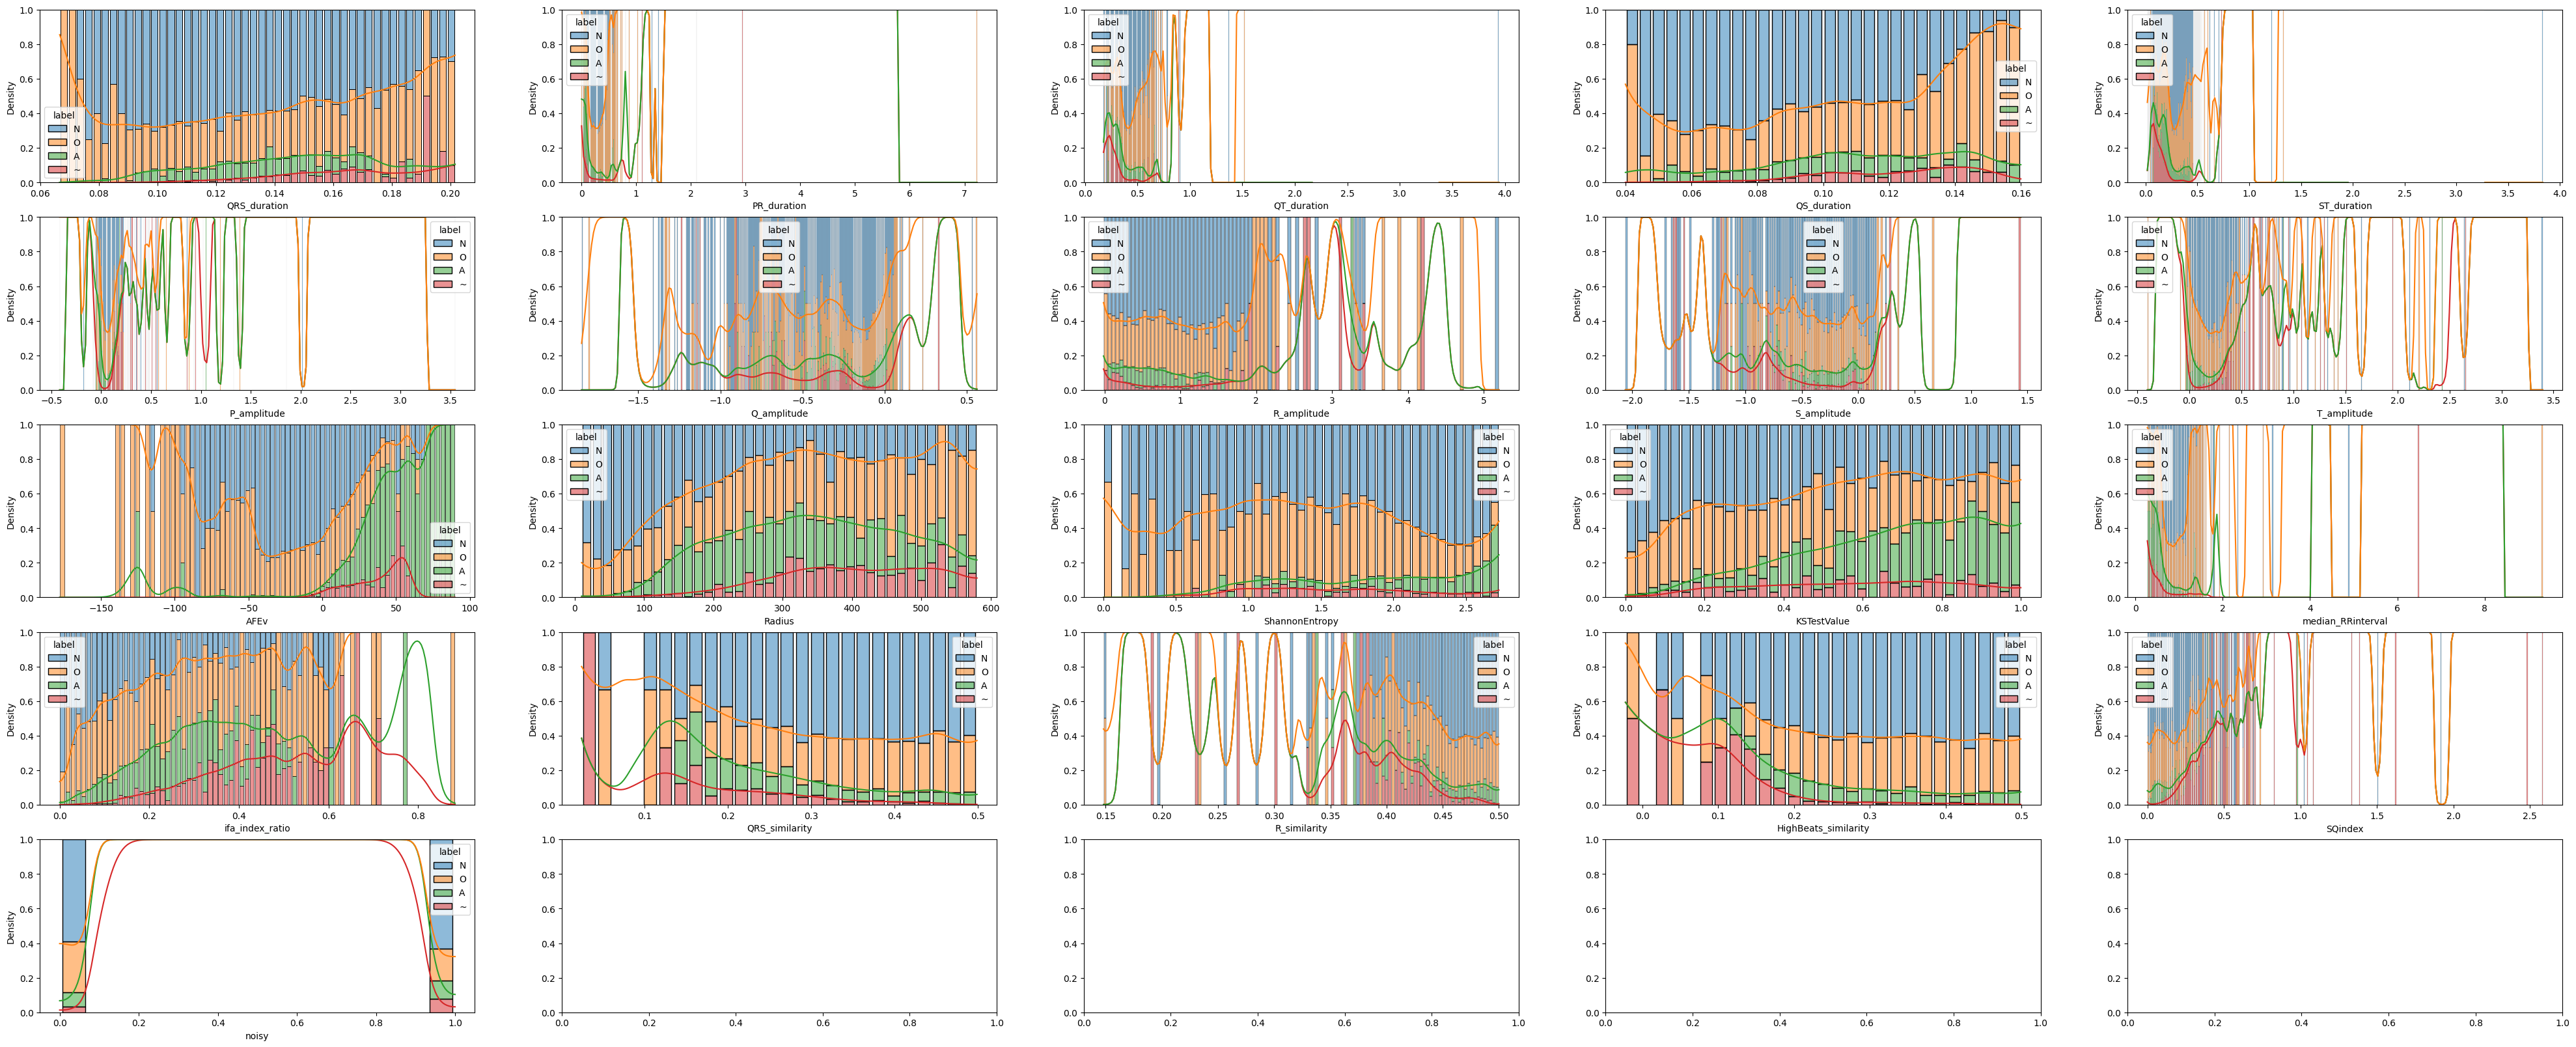

In [23]:
# Plot stratified distribution of labels for each feature
features = data.columns.tolist()
features.remove('label')
features.remove('patient_id')

cols = 5
rows = len(features) // cols + 1

fig, axes = plt.subplots(rows, cols, figsize=(50, 20))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(data=data, x=col, hue='label', ax=axes[i], stat='density', multiple='fill', shrink=0.8, kde=True, legend=True)
plt.show()


array([[<Axes: title={'center': 'QRS_duration'}>,
        <Axes: title={'center': 'PR_duration'}>,
        <Axes: title={'center': 'QT_duration'}>,
        <Axes: title={'center': 'QS_duration'}>,
        <Axes: title={'center': 'ST_duration'}>],
       [<Axes: title={'center': 'P_amplitude'}>,
        <Axes: title={'center': 'Q_amplitude'}>,
        <Axes: title={'center': 'R_amplitude'}>,
        <Axes: title={'center': 'S_amplitude'}>,
        <Axes: title={'center': 'T_amplitude'}>],
       [<Axes: title={'center': 'AFEv'}>,
        <Axes: title={'center': 'Radius'}>,
        <Axes: title={'center': 'ShannonEntropy'}>,
        <Axes: title={'center': 'KSTestValue'}>,
        <Axes: title={'center': 'median_RRinterval'}>],
       [<Axes: title={'center': 'ifa_index_ratio'}>,
        <Axes: title={'center': 'QRS_similarity'}>,
        <Axes: title={'center': 'R_similarity'}>,
        <Axes: title={'center': 'HighBeats_similarity'}>,
        <Axes: title={'center': 'SQindex'}>],
     

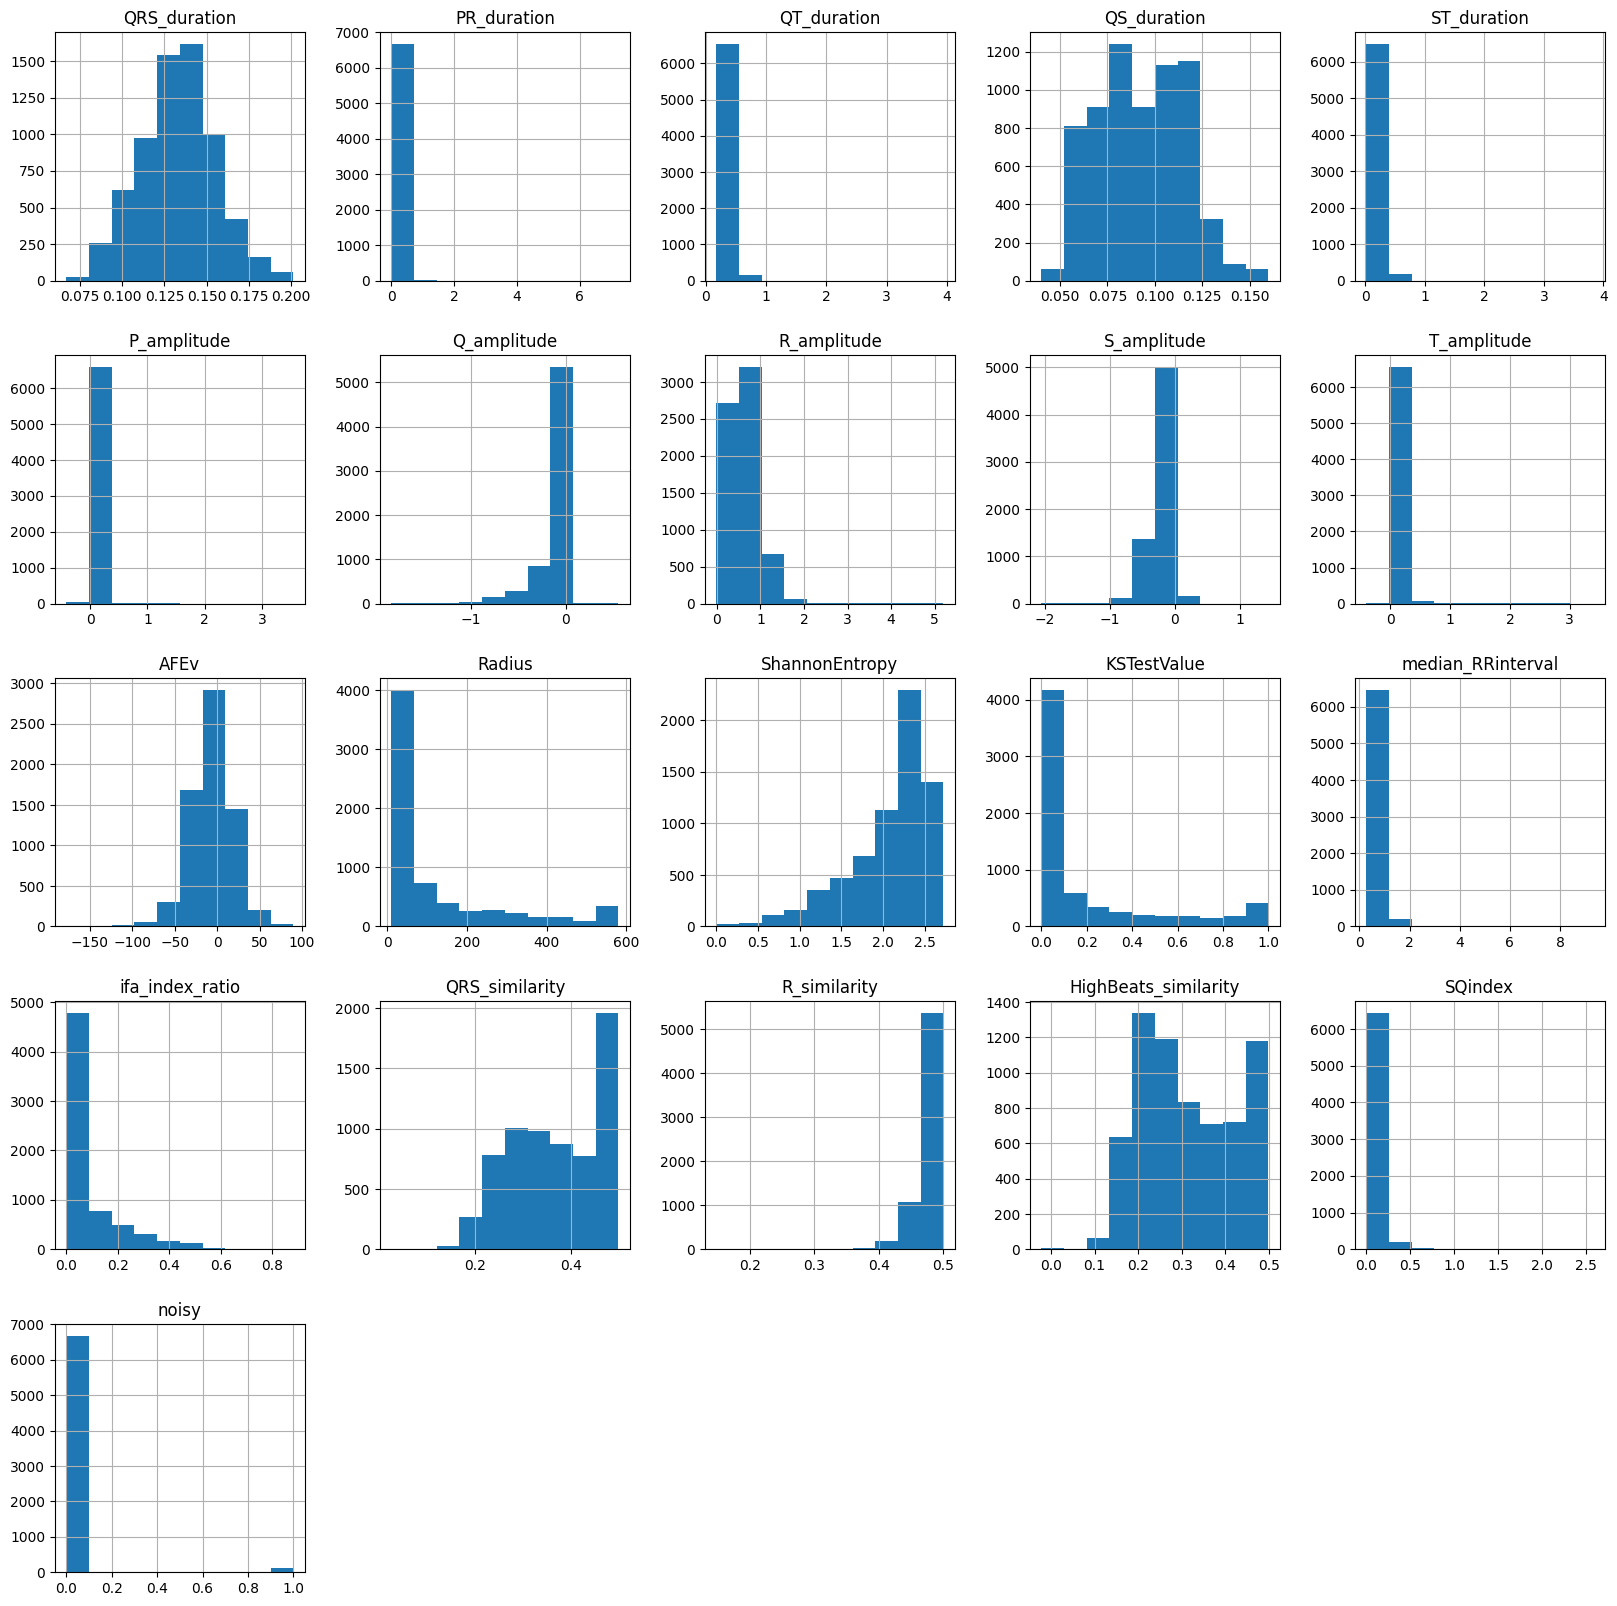

In [16]:
# Plot the distribution of the features
data.hist(figsize=(20,20))

In [24]:
# Plot the correlation matrix
# Compute the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(20, 10))  # Set the figure size if desired
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Add a title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

ValueError: could not convert string to float: 'A00003'

In [26]:
# remove rows with > 60% missing values
data_set = data.dropna(thresh=data.shape[1]*0.6, axis=0, inplace=False)
print("original: ",data.shape)
print("should be: ", data.shape[0] - data[data['noisy']>0].shape[0])
print("now: ", data_set.shape)

original:  (6814, 23)
should be:  6683
now:  (6683, 23)


In [27]:
# Count the number of rows with NaN values using isnull()
rows_with_nans = data.isnull().sum(axis=1)
num_rows_with_nans = len(rows_with_nans[rows_with_nans > 0])
print("Number of rows with NaN values before:", num_rows_with_nans)

# Count the number of rows with NaN values using isnull()
rows_with_nans = data_set.isnull().sum(axis=1)
num_rows_with_nans = len(rows_with_nans[rows_with_nans > 0])
print("Number of rows with NaN values after:", num_rows_with_nans)

Number of rows with NaN values before: 131
Number of rows with NaN values after: 0


In [28]:
# remove rows with > 60% missing values
test_data_set = test_data.dropna(thresh=test_data.shape[1]*0.6, axis=0, inplace=False)
print("original: ",test_data.shape)
print("should be: ", test_data.shape[0] - test_data[test_data['noisy']>0].shape[0])
print("now: ", test_data_set.shape)

# Count the number of rows with NaN values using isnull()
rows_with_nans = test_data.isnull().sum(axis=1)
num_rows_with_nans = len(rows_with_nans[rows_with_nans > 0])
print("Number of rows with NaN values before:", num_rows_with_nans)

# Count the number of rows with NaN values using isnull()
rows_with_nans = test_data_set.isnull().sum(axis=1)
num_rows_with_nans = len(rows_with_nans[rows_with_nans > 0])
print("Number of rows with NaN values after:", num_rows_with_nans)

original:  (1705, 23)
should be:  1666
now:  (1666, 23)
Number of rows with NaN values before: 39
Number of rows with NaN values after: 0


In [29]:
data_set.columns

Index(['patient_id', 'QRS_duration', 'PR_duration', 'QT_duration',
       'QS_duration', 'ST_duration', 'P_amplitude', 'Q_amplitude',
       'R_amplitude', 'S_amplitude', 'T_amplitude', 'AFEv', 'Radius',
       'ShannonEntropy', 'KSTestValue', 'median_RRinterval', 'ifa_index_ratio',
       'QRS_similarity', 'R_similarity', 'HighBeats_similarity', 'SQindex',
       'noisy', 'label'],
      dtype='object')

In [30]:
dataset = data_set

# Split data into features and labels
X = dataset.drop(['label', 'patient_id', 'noisy'], axis=1)
y = dataset['label'].values

print(X.columns)
print(X.shape)
print(y.shape)

Index(['QRS_duration', 'PR_duration', 'QT_duration', 'QS_duration',
       'ST_duration', 'P_amplitude', 'Q_amplitude', 'R_amplitude',
       'S_amplitude', 'T_amplitude', 'AFEv', 'Radius', 'ShannonEntropy',
       'KSTestValue', 'median_RRinterval', 'ifa_index_ratio', 'QRS_similarity',
       'R_similarity', 'HighBeats_similarity', 'SQindex'],
      dtype='object')
(6683, 20)
(6683,)


In [31]:
[x for x in test_data_set['patient_id'] if x in test_data_set['patient_id']]

[]

In [32]:
dataset = test_data_set

# Split data into features and labels
X_test = dataset.drop(['label', 'patient_id', 'noisy'], axis=1)
y_test = dataset['label'].values

print((X_test.columns == X.columns).all())
print(X_test.shape)
print(y_test.shape)

True
(1666, 20)
(1666,)


In [33]:
# Create a Decision Tree classifier
base_classifier = DecisionTreeClassifier()

# Define the parameter grid for random search
param_grid = {
    'estimator__max_depth': randint(1, 10),  # Randomly select max_depth between 1 and 10
    'n_estimators': randint(50, 200),  # Randomly select the number of estimators between 50 and 200
    'learning_rate': [0.01, 0.1, 1.0]  # Specify the learning rates to be considered
}

# Create the AdaBoost classifier with the Decision Tree base classifier
ada_boost = AdaBoostClassifier(base_classifier)

# Perform random search
random_search = RandomizedSearchCV(ada_boost, param_distributions=param_grid, n_iter=10, cv=5)

# Fit the random search to your data
random_search.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
                   param_distributions={'estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D429D0510>,
                                        'learning_rate': [0.01, 0.1, 1.0],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020D5502D310>})

In [34]:
model = random_search.best_estimator_

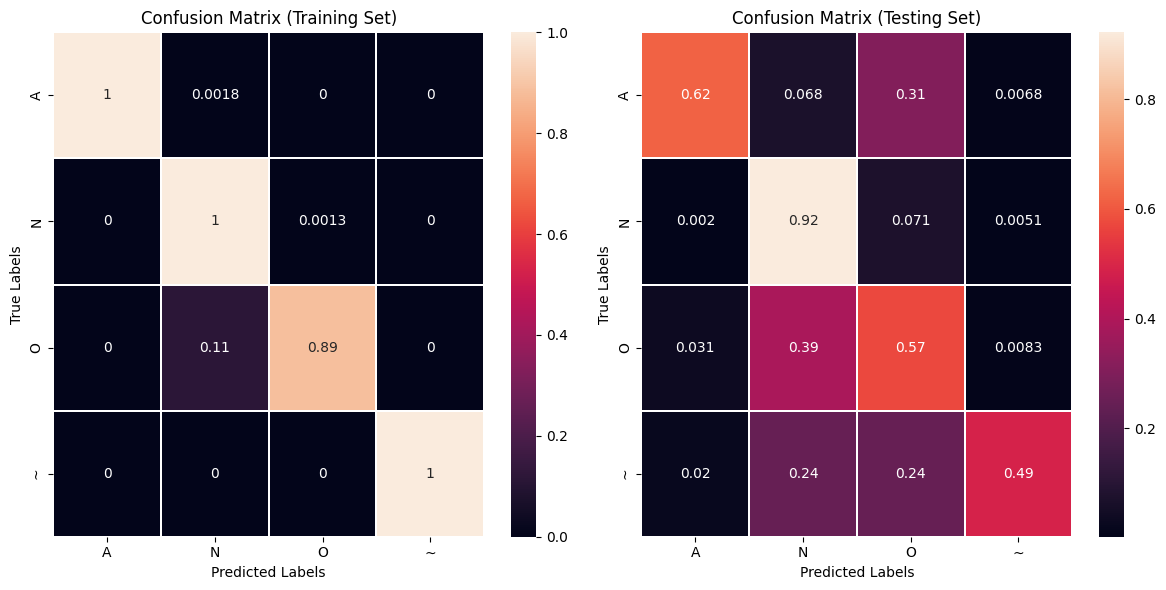

Training Set Metrics:
Accuracy: 0.9657339518180458
F1 Score: 0.9771833553888014
Precision: 0.9858645594981577
Recall: 0.9705208789230844

Testing Set Metrics:
Accuracy: 0.7815126050420168
F1 Score: 0.6939636294183545
Precision: 0.7594404997579804
Recall: 0.6504747732426305


In [35]:
pred_train = model.predict(X) 
pred_test = model.predict(X_test) 

with open(f'model_1.pkl', 'wb') as file: pickle.dump(model,file) 

compute_metrics(y,pred_train,y_test, pred_test, metrics='macro') 